<a href="https://colab.research.google.com/github/srilamaiti/spring_2023_w266_final_project_heesuk_iris_srila/blob/main/srila/ELL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install New Libraries**

In [ ]:
!pip install nltk
!pip install wordcloud
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Importing Libraries**

In [ ]:
#NLP related libraries
import transformers
print(f'transformers version: {transformers.__version__}')
from transformers import logging as hf_logging
from transformers import BertTokenizer, TFBertModel
hf_logging.set_verbosity_error()
import nltk
from nltk.tokenize import sent_tokenize
import spacy      
from spacy import displacy
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from wordcloud import ImageColorGenerator
from sklearn.model_selection import train_test_split
nltk.download('punkt')

# Other required libraries
import os
import pandas as pd
import numpy as np
import re
import copy
import sys
import warnings
warnings.filterwarnings("ignore")

# Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.layer_utils import count_params
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import mae
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from keras.models import load_model

transformers version: 4.27.1


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **General Functions**

# **Set Config Parameters**

In [ ]:
def set_config_param(seed = 99):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.backend.clear_session()
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_columns', None)
    
    
set_config_param(20230214)

# **Count Plot**

In [ ]:
def plot_count(df, labels):
  sns.set_style('whitegrid')
  plt.figure(figsize=(18,10))
  for idx, label in enumerate(labels):
      plt.subplot(2, 3, idx+1)
      sns.countplot(x = label, data = df)

# **Adding Feature Columns**

In [ ]:
def add_feature(df):

    # Cleaning up full_text : Removing tabl and carriage return characters
    df['full_text'] = df["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)

    # Adding word count, sentence count, total score and full text length
    df['word_count'] = df['full_text'].apply(lambda x: len(x.split()))
    df['sentence_count'] = df['full_text'].apply(lambda x: len(sent_tokenize(x)))
    df['total_score'] = df['cohesion'] + df_train['syntax'] + df['vocabulary'] + df['phraseology'] + df['grammar'] + df['conventions']
    df['full_text_len'] = df['full_text'].apply(lambda x: len(x))

    # Adding mean, median score per label and indicator column 
    # whether the label value is below or above mean or median value
    for label in label_cols:
        df[label + '_avg_score'] = np.mean(df[label])
        df[label + '_above_or_below_avg_flag'] = np.where(df[label] > np.mean(df[label]), 1, 0)  
        df[label + '_median_score'] = np.median(df[label])
        df[label + '_above_or_below_median_flag'] = np.where(df[label] > np.median(df[label]), 1, 0)  
        df[label + '_rounded_val'] = np.round(df[label])  
    
    return df

# **Getting Unique Values for Each Label**

In [ ]:
def get_unique_values_for_labels(df, col_list):
    print('Unique Values in Each Metric:\n==================================================')
    for col in col_list:
        print(f'{col}: {df[col].unique()}')

# **Getting Value Counts for Each Label**

In [ ]:
def get_value_counts_for_labels(df, col_list):
    print('Counts for Each Metric:\n==================================================')
    for col in col_list:
        print(f"Column: {col}")
        print(f'{df[col].value_counts().sort_values()}')
        print("*****")

# **Getting Histogram for a Column**

In [ ]:
def get_histogram_for_col(df, col_list, col_name):
    sns.set_style('whitegrid')
    plt.figure(figsize=(18,10))
    for idx, label in enumerate(col_list):
        plt.subplot(2, 3, idx+1)
        sns.histplot(x=col_name, hue = label, data = df)
        plt.xlabel('Word Count', fontsize=10)

# **Getting Count Plot for Indicator Columns**

In [ ]:
def get_count_plot_for_ind_col(df, search_string, col_list):
    fig, ax = plt.subplots(1, len(col_list), figsize=(50,10))
    for idx, label in enumerate(col_list):
        sns.countplot(x = df[label + search_string], ax = ax[idx])
        ax[idx].set_title(label)

# **Getting Bar Plot for Each Label**

In [ ]:
def get_barplot_for_each_label(df, col_list, search_string):
    avg_score_cols = [col + search_string for col in col_list]
    plt.figure(figsize=(8,5))
    ax = sns.barplot(x=col_list, y=np.array(df[avg_score_cols].drop_duplicates())[0], palette='rocket')
    plt.xlabel('Scoring Metric', fontsize=12)
    if search_string == '_avg_score':
        plt.ylabel('Average Score', fontsize=12)
        plt.title('Average Score in Each Metric', fontsize=16)
    elif search_string == '_median_score':
        plt.ylabel('Median Score', fontsize=12)
        plt.title('Median Score in Each Metric', fontsize=16)

# **Label Processing**

In [ ]:
def get_cat_label_cols(col_list):
    return ['cat_' + col for col in col_list]

In [ ]:
def apply_label_map(df, label_map, col_list):
  for col in col_list:
      df[col + '_map'] = df[col].map(label_map)
  return df

In [ ]:
def get_label_values(df, col_list):
    return [np.array(df[col]) for col in col_list]

In [ ]:
def get_label_dict(df, col_list_1, col_list_2):
    return dict(zip(col_list_2, get_label_values(df, col_list_1)))

# **Plot Loss and Accuracy**

In [ ]:
def plot_history(history):
    '''
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(range(0, len(history['loss'] + 1)))
    plt.plot(history['loss'], label="training", marker='o')
    plt.plot(history['val_loss'], label="validation", marker='o')
    plt.legend()
    plt.show()
    '''

    # plot loss for train and validation
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(1, 3, 1)
    plt.plot(history['loss'], lw=2, color='darkgoldenrod')
    plt.plot(history['val_loss'], lw=2, color='indianred')
    plt.legend(['Train', 'Validation'], fontsize=10)
    # plt.ylim(0,1)
    ax.set_xlabel('Epochs', size=10)
    ax.set_title('Loss');

    # plot accuracy for train and validation
    ax = fig.add_subplot(1, 3, 2)
    plt.plot(history['accuracy'], lw=2, color='darkgoldenrod')
    plt.plot(history['val_accuracy'], lw=2, color='indianred')
    plt.legend(['Train', 'Validation'], fontsize=10)
    # plt.ylim(0,1)
    ax.set_xlabel('Epochs', size=10)
    ax.set_title('Accuracy')

# **Read Input Files**

In [ ]:
input_train_df = pd.read_csv('train.csv')
input_test_df = pd.read_csv('test.csv')

float_labels, int_labels = np.arange(1, 5.5, 0.5), np.arange(9)
label_map = dict(zip(float_labels, int_labels))

orig_train_df = copy.deepcopy(input_train_df)
orig_train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [ ]:
label_map

{1.0: 0, 1.5: 1, 2.0: 2, 2.5: 3, 3.0: 4, 3.5: 5, 4.0: 6, 4.5: 7, 5.0: 8}

# **Spliting the Data**

Original test data is very limited, there are only 3 records and it does not have labels to test. So we decided to repurpose the given train data to split into train, test and validation sets.

In [ ]:
shuffle = np.random.permutation(np.arange(orig_train_df.shape[0]))
orig_train_df = orig_train_df.iloc[shuffle]
split=(0.8,0.1,0.1)
splits = np.multiply(len(orig_train_df), split).astype(int)
df_train, df_val, df_test = np.split(orig_train_df, [splits[0], splits[0] + splits[1]])

In [ ]:
label_cols = df_train.columns[2:]
label_rounded_cols = [col + '_rounded_val' for col in label_cols]
label_map_cols = [col + '_map' for col in label_cols]
cat_label_cols = get_cat_label_cols(label_cols)

df_train = apply_label_map(df_train, label_map, label_cols)
df_test = apply_label_map(df_test, label_map, label_cols)
df_val = apply_label_map(df_val, label_map, label_cols)

In [ ]:
label_cols, label_rounded_cols, label_map_cols, cat_label_cols

(Index(['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar',
        'conventions'],
       dtype='object'),
 ['cohesion_rounded_val',
  'syntax_rounded_val',
  'vocabulary_rounded_val',
  'phraseology_rounded_val',
  'grammar_rounded_val',
  'conventions_rounded_val'],
 ['cohesion_map',
  'syntax_map',
  'vocabulary_map',
  'phraseology_map',
  'grammar_map',
  'conventions_map'],
 ['cat_cohesion',
  'cat_syntax',
  'cat_vocabulary',
  'cat_phraseology',
  'cat_grammar',
  'cat_conventions'])

# **Addiung Other Feature Columns**

In [ ]:
df_train = add_feature(df_train)
df_test = add_feature(df_test)
df_val = add_feature(df_val)

# **EDA**

In [ ]:
df_train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cohesion_map,syntax_map,vocabulary_map,phraseology_map,grammar_map,conventions_map,word_count,sentence_count,total_score,full_text_len,cohesion_avg_score,cohesion_above_or_below_avg_flag,cohesion_median_score,cohesion_above_or_below_median_flag,cohesion_rounded_val,syntax_avg_score,syntax_above_or_below_avg_flag,syntax_median_score,syntax_above_or_below_median_flag,syntax_rounded_val,vocabulary_avg_score,vocabulary_above_or_below_avg_flag,vocabulary_median_score,vocabulary_above_or_below_median_flag,vocabulary_rounded_val,phraseology_avg_score,phraseology_above_or_below_avg_flag,phraseology_median_score,phraseology_above_or_below_median_flag,phraseology_rounded_val,grammar_avg_score,grammar_above_or_below_avg_flag,grammar_median_score,grammar_above_or_below_median_flag,grammar_rounded_val,conventions_avg_score,conventions_above_or_below_avg_flag,conventions_median_score,conventions_above_or_below_median_flag,conventions_rounded_val
134,0A8B8F282E45,"Winston Churchill once said ""success consists ...",3.0,2.0,2.5,2.5,2.5,2.5,4,2,3,3,3,3,446,15,15.0,2373,3.128676,0,3.0,0,3.0,3.03133,0,3.0,0,2.0,3.235134,0,3.0,0,2.0,3.123242,0,3.0,0,2.0,3.029252,0,3.0,0,2.0,3.081841,0,3.0,0,2.0
1470,71BA665B1B31,I think that imagination is not more important...,3.0,4.0,3.0,3.5,3.5,3.0,4,6,4,5,5,4,226,14,20.0,1216,3.128676,0,3.0,0,3.0,3.03133,1,3.0,1,4.0,3.235134,0,3.0,0,3.0,3.123242,1,3.0,1,4.0,3.029252,1,3.0,1,4.0,3.081841,0,3.0,0,3.0
1216,5EA71157D48F,I supported that people make their own decisio...,2.5,2.5,2.5,2.5,3.0,3.5,3,3,3,3,4,5,164,7,16.5,841,3.128676,0,3.0,0,2.0,3.03133,0,3.0,0,2.0,3.235134,0,3.0,0,2.0,3.123242,0,3.0,0,2.0,3.029252,0,3.0,0,3.0,3.081841,1,3.0,1,4.0
3705,F7B5DF87EA1D,"If we didn't take a action, What should we do?...",2.5,2.5,3.0,3.0,3.5,3.5,3,3,4,4,5,5,347,25,18.0,1876,3.128676,0,3.0,0,2.0,3.03133,0,3.0,0,2.0,3.235134,0,3.0,0,3.0,3.123242,0,3.0,0,3.0,3.029252,1,3.0,1,4.0,3.081841,1,3.0,1,4.0
2121,9EBCC1131B13,"As we have two different people, we have two t...",4.5,3.0,4.0,3.5,3.0,3.5,7,4,6,5,4,5,573,19,21.5,3176,3.128676,1,3.0,1,4.0,3.03133,0,3.0,0,3.0,3.235134,1,3.0,1,4.0,3.123242,1,3.0,1,4.0,3.029252,0,3.0,0,3.0,3.081841,1,3.0,1,4.0


In [ ]:
for col in label_cols:
    print(df_train[col + '_rounded_val'].unique())

[3. 2. 4. 1. 5.]
[2. 4. 3. 1. 5.]
[2. 3. 4. 1. 5.]
[2. 4. 3. 5. 1.]
[2. 4. 3. 1. 5.]
[2. 3. 4. 1. 5.]


In [ ]:
df_train.iloc[0]

text_id                                                                        0A8B8F282E45
full_text                                 Winston Churchill once said "success consists ...
cohesion                                                                                3.0
syntax                                                                                  2.0
vocabulary                                                                              2.5
phraseology                                                                             2.5
grammar                                                                                 2.5
conventions                                                                             2.5
cohesion_map                                                                              4
syntax_map                                                                                2
vocabulary_map                                                                  

In [ ]:
df_test.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cohesion_map,syntax_map,vocabulary_map,phraseology_map,grammar_map,conventions_map,word_count,sentence_count,total_score,full_text_len,cohesion_avg_score,cohesion_above_or_below_avg_flag,cohesion_median_score,cohesion_above_or_below_median_flag,cohesion_rounded_val,syntax_avg_score,syntax_above_or_below_avg_flag,syntax_median_score,syntax_above_or_below_median_flag,syntax_rounded_val,vocabulary_avg_score,vocabulary_above_or_below_avg_flag,vocabulary_median_score,vocabulary_above_or_below_median_flag,vocabulary_rounded_val,phraseology_avg_score,phraseology_above_or_below_avg_flag,phraseology_median_score,phraseology_above_or_below_median_flag,phraseology_rounded_val,grammar_avg_score,grammar_above_or_below_avg_flag,grammar_median_score,grammar_above_or_below_median_flag,grammar_rounded_val,conventions_avg_score,conventions_above_or_below_avg_flag,conventions_median_score,conventions_above_or_below_median_flag,conventions_rounded_val
3317,E587CBD5D1E4,How we know the first impression is important ...,3.5,2.5,3.5,3.5,2.5,3.0,5,3,5,5,3,4,265,8,NaN,1350,3.105867,1,3.0,1,4.0,3.010204,0,3.0,0,2.0,3.242347,1,3.0,1,4.0,3.067602,1,3.0,1,4.0,3.042092,0,3.0,0,2.0,3.068878,0,3.0,0,3.0
3172,DF149975C610,I agree with emerson's statement. I will grow ...,3.0,3.0,3.0,3.5,2.5,3.0,4,4,4,5,3,4,502,39,NaN,2534,3.105867,0,3.0,0,3.0,3.010204,0,3.0,0,3.0,3.242347,0,3.0,0,3.0,3.067602,1,3.0,1,4.0,3.042092,0,3.0,0,2.0,3.068878,0,3.0,0,3.0
2999,D7301CAAFAB0,When are parents gave us advice we are able to...,2.5,2.0,2.5,2.0,2.0,3.0,3,2,3,2,2,4,496,27,NaN,2449,3.105867,0,3.0,0,2.0,3.010204,0,3.0,0,2.0,3.242347,0,3.0,0,2.0,3.067602,0,3.0,0,2.0,3.042092,0,3.0,0,2.0,3.068878,0,3.0,0,3.0
2824,CDDCA13DB734,The determination make us to do something and ...,3.5,3.0,3.0,2.5,2.5,3.5,5,4,4,3,3,5,309,14,NaN,1567,3.105867,1,3.0,1,4.0,3.010204,0,3.0,0,3.0,3.242347,0,3.0,0,3.0,3.067602,0,3.0,0,2.0,3.042092,0,3.0,0,2.0,3.068878,1,3.0,1,4.0
310,16B9EB49892E,"The should be people make their own decision, ...",2.5,2.5,2.5,2.0,2.5,2.0,3,3,3,2,3,2,169,9,NaN,926,3.105867,0,3.0,0,2.0,3.010204,0,3.0,0,2.0,3.242347,0,3.0,0,2.0,3.067602,0,3.0,0,2.0,3.042092,0,3.0,0,2.0,3.068878,0,3.0,0,2.0


In [ ]:
df_val.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cohesion_map,syntax_map,vocabulary_map,phraseology_map,grammar_map,conventions_map,word_count,sentence_count,total_score,full_text_len,cohesion_avg_score,cohesion_above_or_below_avg_flag,cohesion_median_score,cohesion_above_or_below_median_flag,cohesion_rounded_val,syntax_avg_score,syntax_above_or_below_avg_flag,syntax_median_score,syntax_above_or_below_median_flag,syntax_rounded_val,vocabulary_avg_score,vocabulary_above_or_below_avg_flag,vocabulary_median_score,vocabulary_above_or_below_median_flag,vocabulary_rounded_val,phraseology_avg_score,phraseology_above_or_below_avg_flag,phraseology_median_score,phraseology_above_or_below_median_flag,phraseology_rounded_val,grammar_avg_score,grammar_above_or_below_avg_flag,grammar_median_score,grammar_above_or_below_median_flag,grammar_rounded_val,conventions_avg_score,conventions_above_or_below_avg_flag,conventions_median_score,conventions_above_or_below_median_flag,conventions_rounded_val
299,16005A45A20A,There's 90% of people in the world that wants ...,4.0,3.0,3.0,3.0,3.5,3.5,6,4,4,4,5,5,1072,47,NaN,5449,3.13555,1,3.0,1,4.0,3.021739,0,3.0,0,3.0,3.234015,0,3.0,0,3.0,3.11509,0,3.0,0,3.0,3.05243,1,3.0,1,4.0,3.086957,1,3.0,1,4.0
1371,698A3F2B43B9,Have you ever thought about staring your futur...,4.0,3.0,4.0,3.5,3.5,3.0,6,4,6,5,5,4,650,29,NaN,3372,3.13555,1,3.0,1,4.0,3.021739,0,3.0,0,3.0,3.234015,1,3.0,1,4.0,3.11509,1,3.0,1,4.0,3.05243,1,3.0,1,4.0,3.086957,0,3.0,0,3.0
3087,DB34A89420F2,I understand why you want to add an hour and t...,2.5,3.0,3.0,2.5,3.5,3.0,3,4,4,3,5,4,486,13,NaN,2508,3.13555,0,3.0,0,2.0,3.021739,0,3.0,0,3.0,3.234015,0,3.0,0,3.0,3.11509,0,3.0,0,2.0,3.05243,1,3.0,1,4.0,3.086957,0,3.0,0,3.0
1047,4FE6EABBFC00,One topic that is frequently debated is if peo...,5.0,4.5,4.0,4.5,4.0,4.5,8,7,6,7,6,7,194,10,NaN,1128,3.13555,1,3.0,1,5.0,3.021739,1,3.0,1,4.0,3.234015,1,3.0,1,4.0,3.11509,1,3.0,1,4.0,3.05243,1,3.0,1,4.0,3.086957,1,3.0,1,4.0
1453,6FEF6D46714D,Has it ever crossed your mind that people toda...,2.5,3.5,3.5,3.5,3.5,2.5,3,5,5,5,5,3,597,27,NaN,3239,3.13555,0,3.0,0,2.0,3.021739,1,3.0,1,4.0,3.234015,1,3.0,1,4.0,3.11509,1,3.0,1,4.0,3.05243,1,3.0,1,4.0,3.086957,0,3.0,0,2.0


In [ ]:
df_train.shape, df_test.shape, df_val.shape

((3128, 48), (392, 48), (391, 48))

In [ ]:
df_train.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cohesion_map,syntax_map,vocabulary_map,phraseology_map,grammar_map,conventions_map,word_count,sentence_count,total_score,full_text_len,cohesion_avg_score,cohesion_above_or_below_avg_flag,cohesion_median_score,cohesion_above_or_below_median_flag,cohesion_rounded_val,syntax_avg_score,syntax_above_or_below_avg_flag,syntax_median_score,syntax_above_or_below_median_flag,syntax_rounded_val,vocabulary_avg_score,vocabulary_above_or_below_avg_flag,vocabulary_median_score,vocabulary_above_or_below_median_flag,vocabulary_rounded_val,phraseology_avg_score,phraseology_above_or_below_avg_flag,phraseology_median_score,phraseology_above_or_below_median_flag,phraseology_rounded_val,grammar_avg_score,grammar_above_or_below_avg_flag,grammar_median_score,grammar_above_or_below_median_flag,grammar_rounded_val,conventions_avg_score,conventions_above_or_below_avg_flag,conventions_median_score,conventions_above_or_below_median_flag,conventions_rounded_val
count,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.0,3128.000000,3128.000000,3128.00000,3128.000000,3128.0,3128.000000,3128.000000,3.128000e+03,3128.000000,3128.0,3128.000000,3128.000000,3.128000e+03,3128.000000,3128.0,3128.000000,3128.000000,3128.000000,3128.000000,3128.0,3128.000000,3128.000000,3.128000e+03,3128.000000,3128.0,3128.000000,3128.000000
mean,3.128676,3.031330,3.235134,3.123242,3.029252,3.081841,4.257353,4.062660,4.470269,4.246483,4.058504,4.163683,431.981458,18.178708,18.629476,2341.242327,3.128676,0.429348,3.0,0.429348,3.143542,3.03133,0.351662,3.0,0.351662,3.023338,3.235134e+00,0.445332,3.0,0.445332,3.283887,3.123242e+00,0.417519,3.0,0.417519,3.130754,3.029252,0.378836,3.0,0.378836,3.018862,3.081841e+00,0.397059,3.0,0.397059,3.086637
std,0.660566,0.642023,0.582582,0.656872,0.697791,0.670081,1.321132,1.284046,1.165164,1.313744,1.395581,1.340161,191.928298,10.181360,3.355094,1029.872033,0.000000,0.495062,0.0,0.495062,0.853247,0.00000,0.477566,0.0,0.477566,0.838645,4.441602e-16,0.497082,0.0,0.497082,0.755728,4.441602e-16,0.493229,0.0,0.493229,0.847789,0.000000,0.485175,0.0,0.485175,0.876785,4.441602e-16,0.489367,0.0,0.489367,0.855674
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51.000000,1.000000,6.000000,269.000000,3.128676,0.000000,3.0,0.000000,1.000000,3.03133,0.000000,3.0,0.000000,1.000000,3.235134e+00,0.000000,3.0,0.000000,1.000000,3.123242e+00,0.000000,3.0,0.000000,1.000000,3.029252,0.000000,3.0,0.000000,1.000000,3.081841e+00,0.000000,3.0,0.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000,3.000000,3.000000,4.000000,3.000000,3.000000,3.000000,294.750000,10.000000,16.000000,1601.000000,3.128676,0.000000,3.0,0.000000,2.000000,3.03133,0.000000,3.0,0.000000,2.000000,3.235134e+00,0.000000,3.0,0.000000,3.000000,3.123242e+00,0.000000,3.0,0.000000,2.000000,3.029252,0.000000,3.0,0.000000,2.000000,3.081841e+00,0.000000,3.0,0.000000,2.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,401.000000,17.000000,18.500000,2174.000000,3.128676,0.000000,3.0,0.000000,3.000000,3.03133,0.000000,3.0,0.000000,3.000000,3.235134e+00,0.000000,3.0,0.000000,3.000000,3.123242e+00,0.000000,3.0,0.000000,3.000000,3.029252,0.000000,3.0,0.000000,3.000000,3.081841e+00,0.000000,3.0,0.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,530.000000,24.000000,21.000000,2869.250000,3.128676,1.000000,3.0,1.000000,4.000000,3.03133,1.000000,3.0,1.000000,4.000000,3.235134e+00,1.000000,3.0,1.000000,4.000000,3.123242e+00,1.000000,3.0,1.000000,4.000000,3.029252,1.000000,3.0,1.000000,4.000000,3.081841e+00,1.000000,3.0,1.000000,4.000000
max,5.000000,5.000000,5.000000,5

In [ ]:
df_train.columns

Index(['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary',
       'phraseology', 'grammar', 'conventions', 'cohesion_map', 'syntax_map',
       'vocabulary_map', 'phraseology_map', 'grammar_map', 'conventions_map',
       'word_count', 'sentence_count', 'total_score', 'full_text_len',
       'cohesion_avg_score', 'cohesion_above_or_below_avg_flag',
       'cohesion_median_score', 'cohesion_above_or_below_median_flag',
       'cohesion_rounded_val', 'syntax_avg_score',
       'syntax_above_or_below_avg_flag', 'syntax_median_score',
       'syntax_above_or_below_median_flag', 'syntax_rounded_val',
       'vocabulary_avg_score', 'vocabulary_above_or_below_avg_flag',
       'vocabulary_median_score', 'vocabulary_above_or_below_median_flag',
       'vocabulary_rounded_val', 'phraseology_avg_score',
       'phraseology_above_or_below_avg_flag', 'phraseology_median_score',
       'phraseology_above_or_below_median_flag', 'phraseology_rounded_val',
       'grammar_avg_score', 'grammar_

# **Unique Values for Each Label**

In [ ]:
get_unique_values_for_labels(df_train, label_cols)

Unique Values in Each Metric:
cohesion: [3.  2.5 4.5 2.  3.5 4.  1.  5.  1.5]
syntax: [2.  4.  2.5 3.  3.5 4.5 1.  5.  1.5]
vocabulary: [2.5 3.  4.  3.5 2.  4.5 1.5 1.  5. ]
phraseology: [2.5 3.5 3.  4.  5.  2.  4.5 1.  1.5]
grammar: [2.5 3.5 3.  2.  4.5 4.  1.  5.  1.5]
conventions: [2.5 3.  3.5 4.  2.  4.5 1.  1.5 5. ]


# **Unique Values for Each Rounded Label**

In [ ]:
get_unique_values_for_labels(df_train, label_rounded_cols)

Unique Values in Each Metric:
cohesion_rounded_val: [3. 2. 4. 1. 5.]
syntax_rounded_val: [2. 4. 3. 1. 5.]
vocabulary_rounded_val: [2. 3. 4. 1. 5.]
phraseology_rounded_val: [2. 4. 3. 5. 1.]
grammar_rounded_val: [2. 4. 3. 1. 5.]
conventions_rounded_val: [2. 3. 4. 1. 5.]


# **Value Counts for Each Label**

In [ ]:
get_value_counts_for_labels(df_train, label_cols)

Counts for Each Metric:
Column: cohesion
1.0      8
1.5     21
5.0     22
4.5     90
2.0    251
4.0    441
2.5    628
3.5    790
3.0    877
Name: cohesion, dtype: int64
*****
Column: syntax
1.0      7
5.0     15
1.5     24
4.5     81
4.0    307
2.0    314
2.5    690
3.5    697
3.0    993
Name: syntax, dtype: int64
*****
Column: vocabulary
1.0       2
1.5      10
5.0      34
4.5      91
2.0      98
2.5     427
4.0     455
3.5     813
3.0    1198
Name: vocabulary, dtype: int64
*****
Column: phraseology
1.0      7
1.5      8
5.0     21
4.5     90
2.0    276
4.0    446
2.5    620
3.5    749
3.0    911
Name: phraseology, dtype: int64
*****
Column: grammar
1.0      5
1.5     14
5.0     21
4.5    109
4.0    351
2.0    449
2.5    674
3.5    704
3.0    801
Name: grammar, dtype: int64
*****
Column: conventions
1.0     14
1.5     15
5.0     18
4.5     96
2.0    317
4.0    388
2.5    629
3.5    740
3.0    911
Name: conventions, dtype: int64
*****


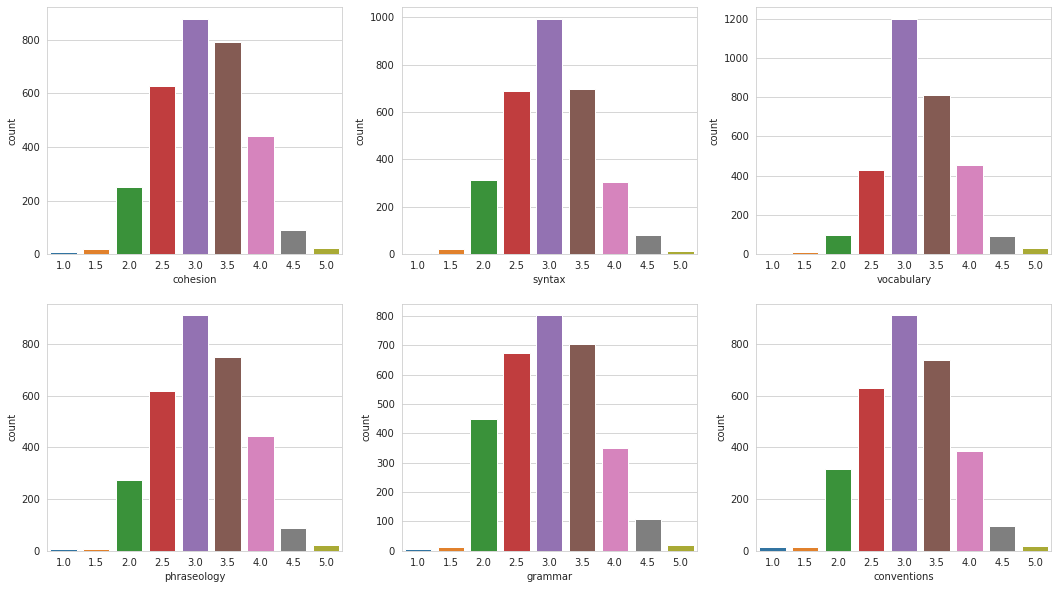

In [ ]:
plot_count(df_train, label_cols)

# **Value Counts for Each Rounded Label**

In [ ]:
get_value_counts_for_labels(df_train, label_rounded_cols)

Counts for Each Metric:
Column: cohesion_rounded_val
1.0       8
5.0      22
3.0     877
2.0     900
4.0    1321
Name: cohesion_rounded_val, dtype: int64
*****
Column: syntax_rounded_val
1.0       7
5.0      15
3.0     993
2.0    1028
4.0    1085
Name: syntax_rounded_val, dtype: int64
*****
Column: vocabulary_rounded_val
1.0       2
5.0      34
2.0     535
3.0    1198
4.0    1359
Name: vocabulary_rounded_val, dtype: int64
*****
Column: phraseology_rounded_val
1.0       7
5.0      21
2.0     904
3.0     911
4.0    1285
Name: phraseology_rounded_val, dtype: int64
*****
Column: grammar_rounded_val
1.0       5
5.0      21
3.0     801
2.0    1137
4.0    1164
Name: grammar_rounded_val, dtype: int64
*****
Column: conventions_rounded_val
1.0      14
5.0      18
3.0     911
2.0     961
4.0    1224
Name: conventions_rounded_val, dtype: int64
*****


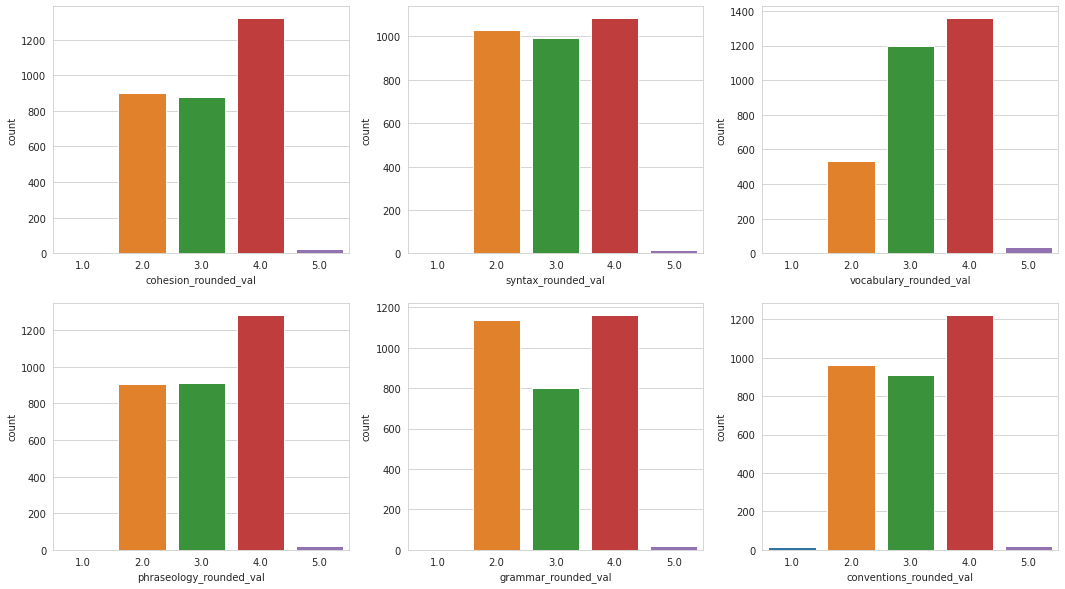

In [ ]:
plot_count(df_train, label_rounded_cols)

# **Full Text Length Stats**

In [ ]:
df_train.full_text.str.len().describe()

count    3128.000000
mean     2341.242327
std      1029.872033
min       269.000000
25%      1601.000000
50%      2174.000000
75%      2869.250000
max      6044.000000
Name: full_text, dtype: float64

# **Word Count Stats**

In [ ]:
df_train.word_count.describe()

count    3128.000000
mean      431.981458
std       191.928298
min        51.000000
25%       294.750000
50%       401.000000
75%       530.000000
max      1260.000000
Name: word_count, dtype: float64

# **Sentence Count Stats**

In [ ]:
df_train.sentence_count.describe()

count    3128.000000
mean       18.178708
std        10.181360
min         1.000000
25%        10.000000
50%        17.000000
75%        24.000000
max        99.000000
Name: sentence_count, dtype: float64

In [ ]:
df_train[df_train.sentence_count == 1][['full_text']]

,full_text
1080,dear TEACHER_NAME i think the you should let s...
272,The year book is for to not forget anything an...
39,my name is Generic_Name and my story is about ...
1848,well people has deferent opinion's about commu...
3557,is number 1 because same time samtin import is...
800,I disagree that first impressions are almost ...
3607,Being yourself doesn't depends in how people s...
3134,Mr; Generic_Name please let me explain The ben...
2250,"when people ask for advice, sometimes seeking ..."
1139,A small kindness can change a person because i...


# **Visualization**

# **Corelation Matrix of the Label Columns**

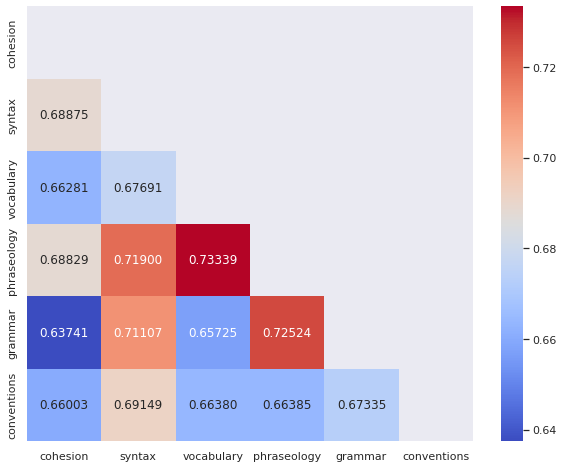

In [ ]:
corr = df_train[label_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype = bool))

sns.set(rc = {"figure.figsize": (10, 8)})

sns.heatmap(corr, 
            annot = True, 
            cmap = "coolwarm", 
            mask = mask,
            fmt  = ".5f")
plt.show()

# **Essay Length, Word Count, Total Score, Sentence Count Distribution**

Essay length, word count and sentence count diostributions have normal shape, though left skewed. Total score distribution looks bi-modal.

Text(0.5, 1.0, 'Sentence Count Distribution')

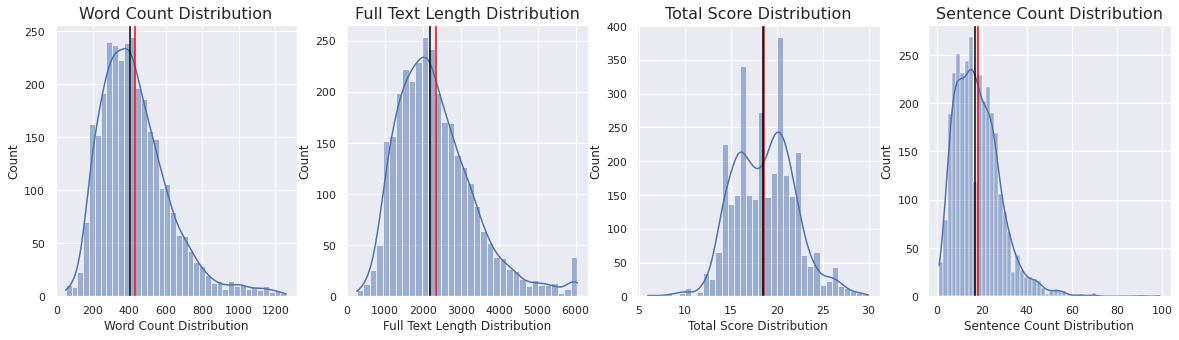

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
sns.histplot(data=df_train, x='word_count', kde=True)
plt.axvline(x=df_train['word_count'].mean(),color='red')
plt.axvline(x=df_train['word_count'].median(),color='black')
plt.xlabel('Word Count Distribution',fontsize=12)
plt.title('Word Count Distribution',fontsize=16)

plt.subplot(1,4,2)
sns.histplot(data=df_train, x='full_text_len', kde=True)
plt.axvline(x=df_train['full_text_len'].mean(),color='red')
plt.axvline(x=df_train['full_text_len'].median(),color='black')
plt.xlabel('Full Text Length Distribution',fontsize=12)
plt.title('Full Text Length Distribution',fontsize=16)

plt.subplot(1,4,3)
sns.histplot(data=df_train, x='total_score', kde=True)
plt.axvline(x=df_train['total_score'].mean(),color='red')
plt.axvline(x=df_train['total_score'].median(),color='black')
plt.xlabel('Total Score Distribution',fontsize=12)
plt.title('Total Score Distribution',fontsize=16)

plt.subplot(1,4,4)
sns.histplot(data=df_train, x='sentence_count', kde=True)
plt.axvline(x=df_train['sentence_count'].mean(),color='red')
plt.axvline(x=df_train['sentence_count'].median(),color='black')
plt.xlabel('Sentence Count Distribution',fontsize=12)
plt.title('Sentence Count Distribution',fontsize=16)

# **Word Count Vs Individual Label Scores**

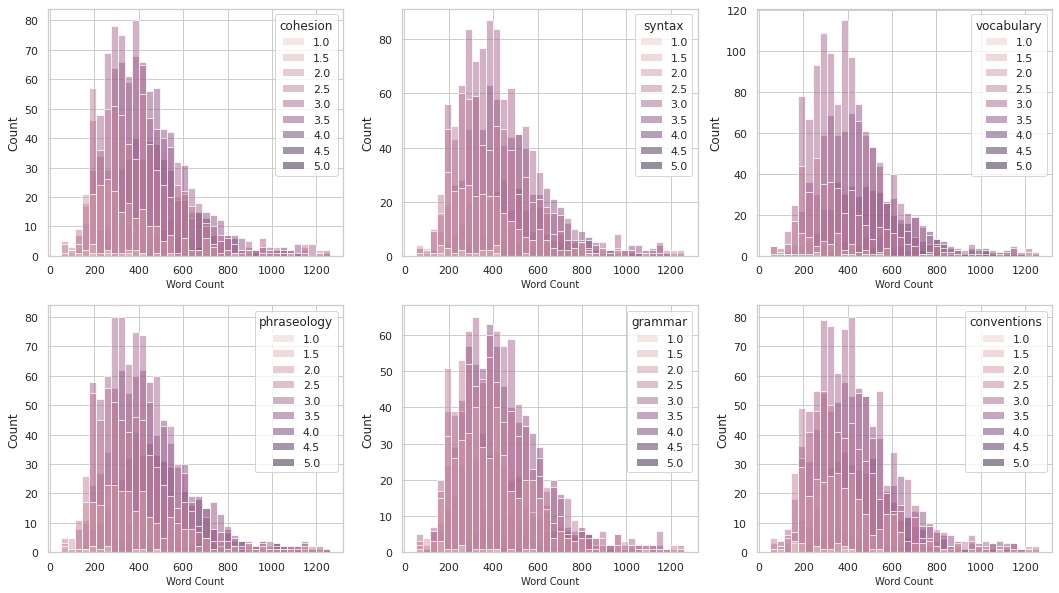

In [ ]:
get_histogram_for_col(df_train, label_cols, 'word_count')

# **Word Count Vs Individual Rounded Label Scores**

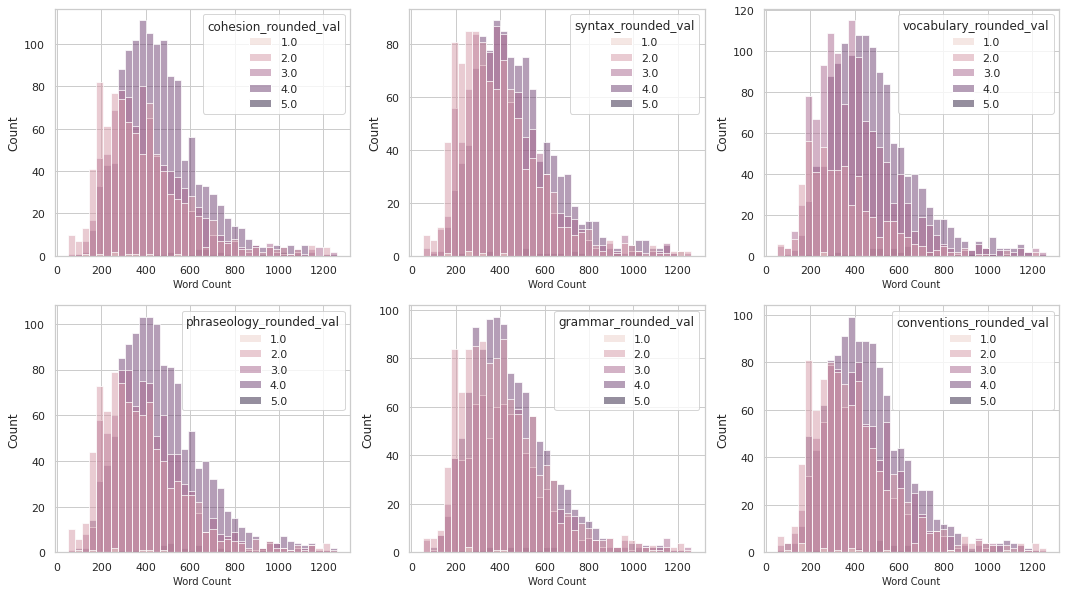

In [ ]:
get_histogram_for_col(df_train, label_rounded_cols, 'word_count')

# **Sentence Count Vs Individual Label Scores**

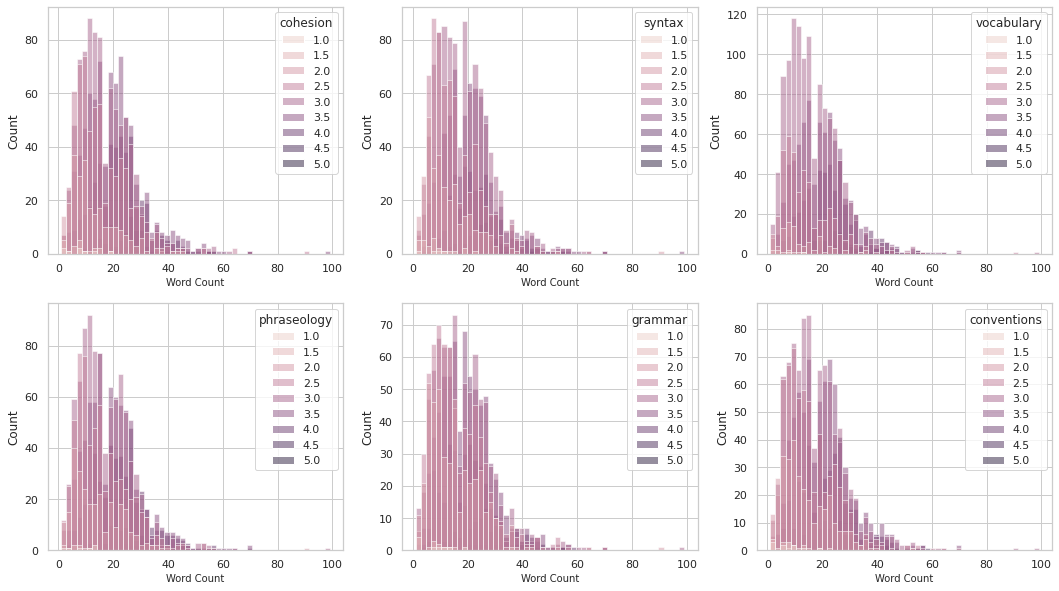

In [ ]:
get_histogram_for_col(df_train, label_cols, 'sentence_count')

# **Sentence Count Vs Individual Rounded Label Scores**

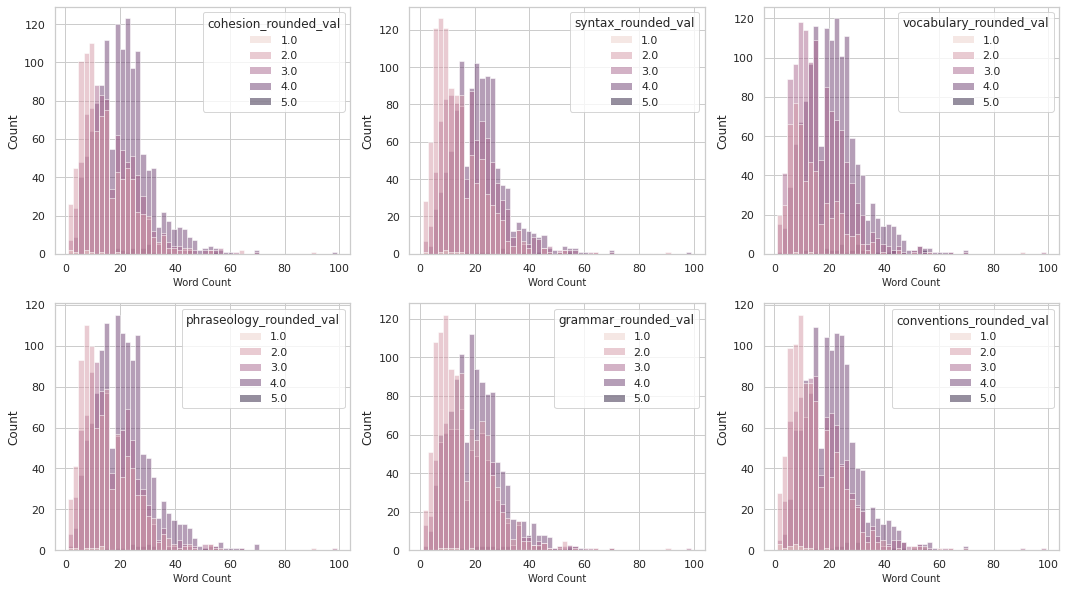

In [ ]:
get_histogram_for_col(df_train, label_rounded_cols, 'sentence_count')

# **Distribution of Labels Above and Below Average in the Respective Category**

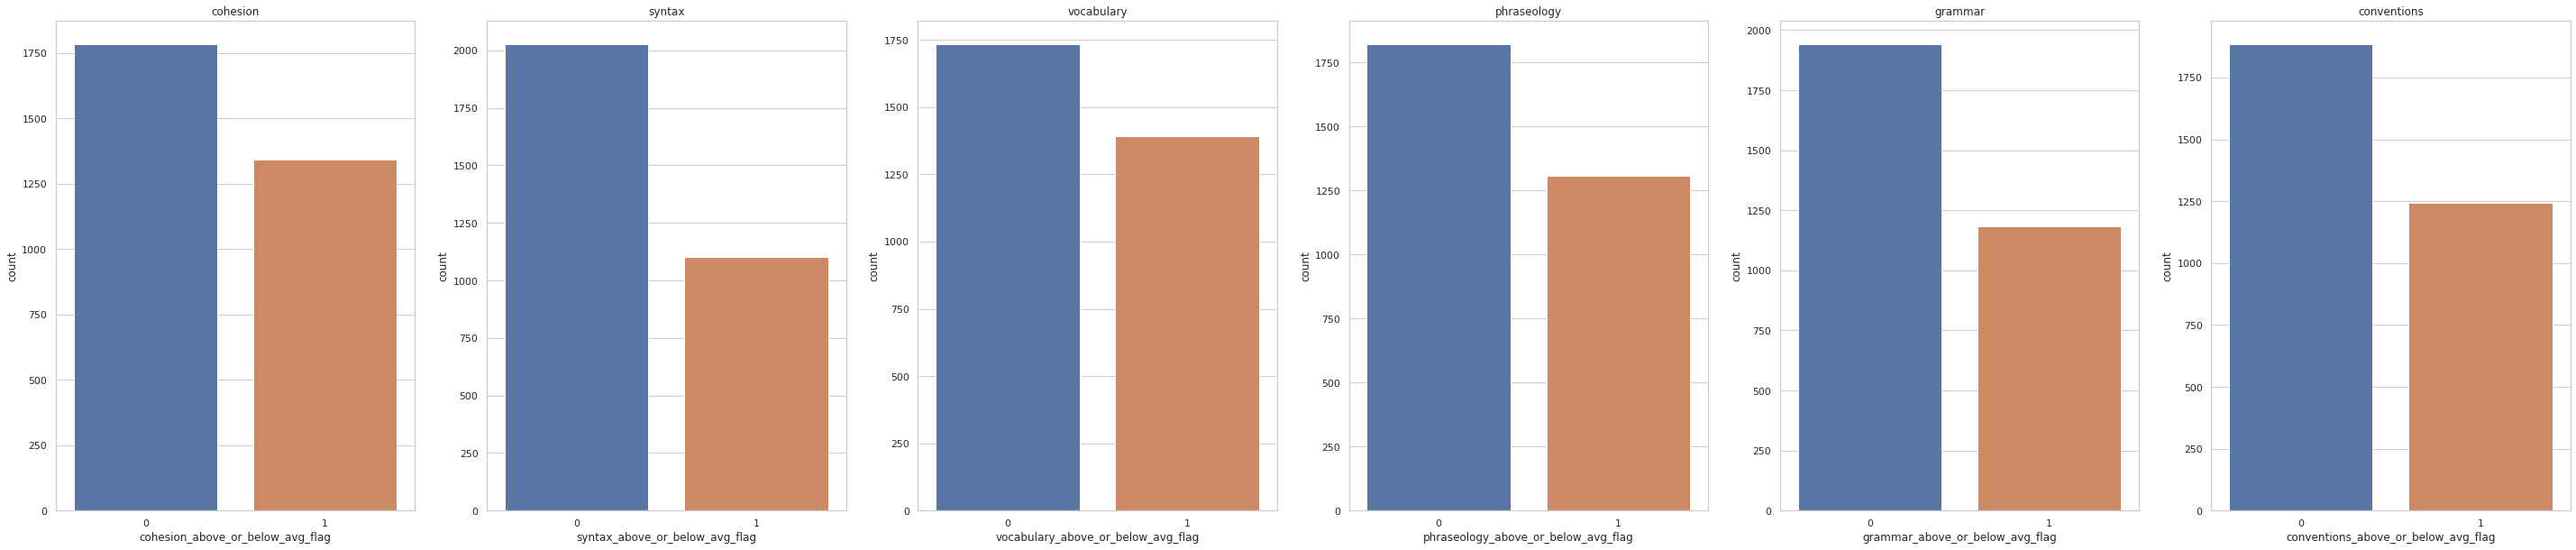

In [ ]:
get_count_plot_for_ind_col(df_train, '_above_or_below_avg_flag', label_cols)

# **Distribution of Labels Above and Below Median in the Respective Category**

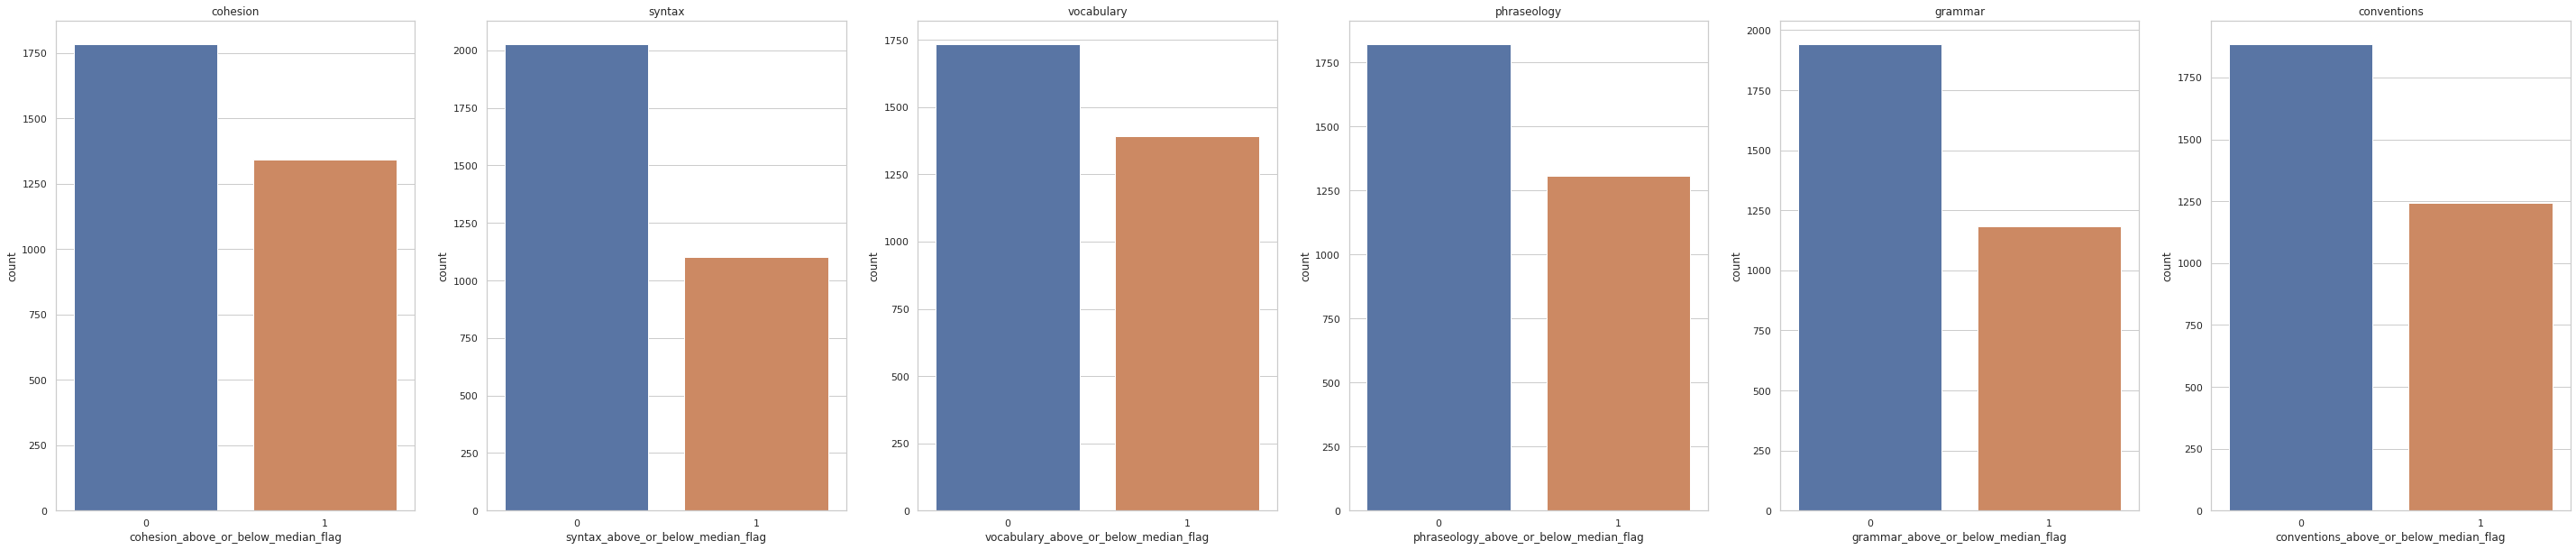

In [ ]:
get_count_plot_for_ind_col(df_train, '_above_or_below_median_flag', label_cols)

For all the labels we see that most of the label values are below average and median values.

# **Distribution of Labels**

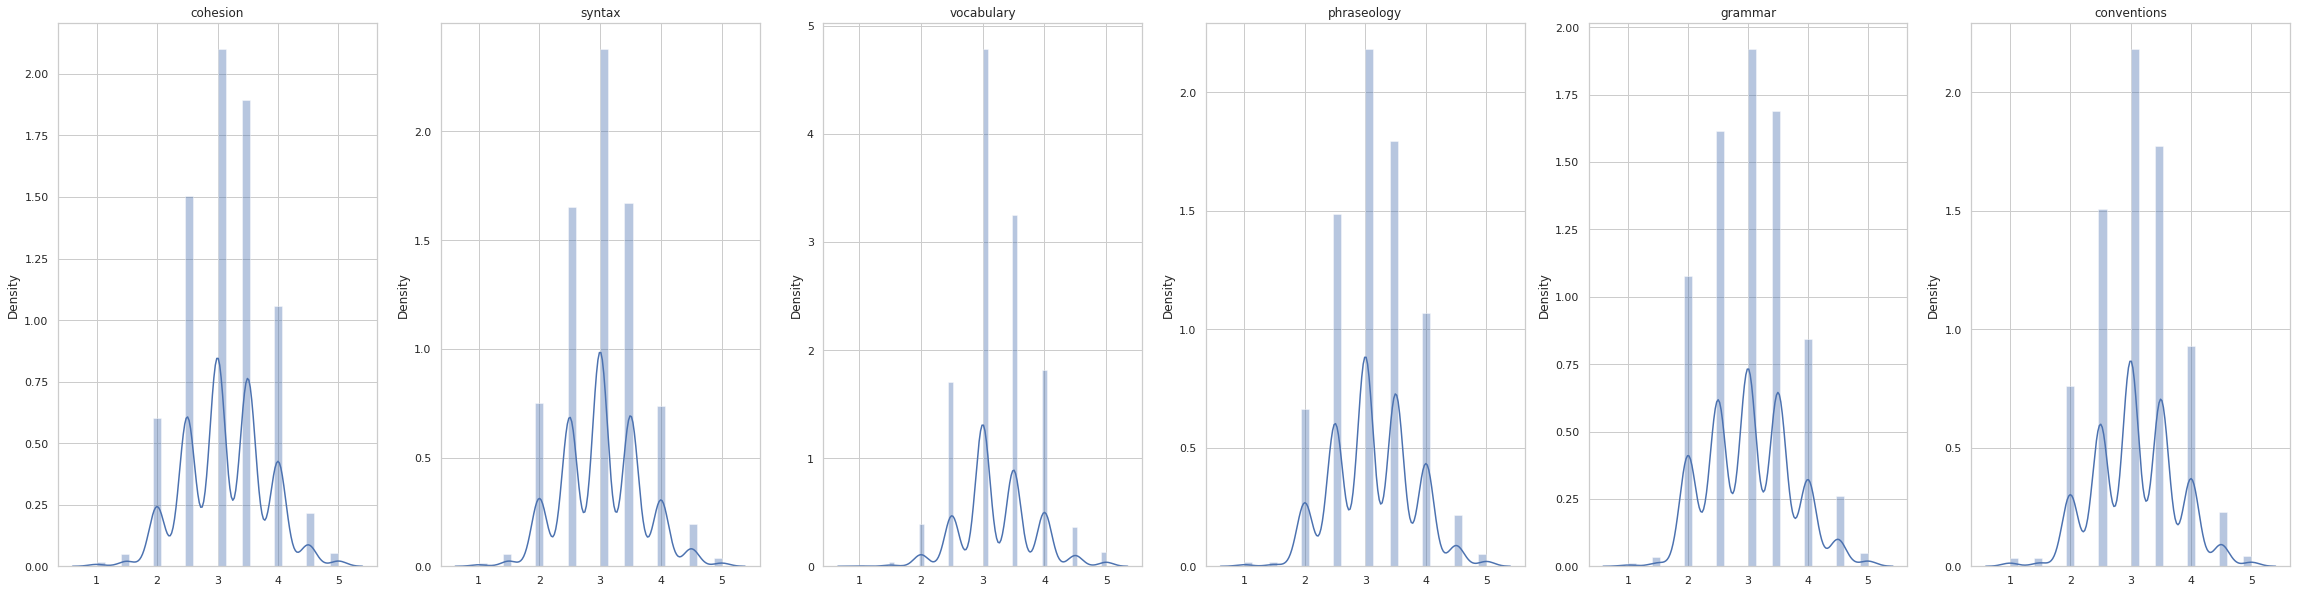

In [ ]:
fig, ax = plt.subplots(1, len(label_cols), figsize=(40,10))

for idx, label in enumerate(label_cols):
    sns.distplot(x = df_train[label],
                 ax = ax[idx]
                )
    ax[idx].set_title(label)
    #plt.show(block = False)

# **Average Score Per Label**

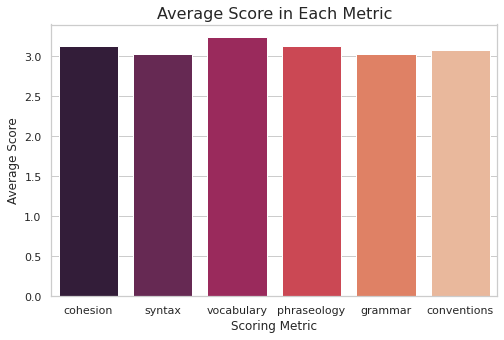

In [ ]:
get_barplot_for_each_label(df_train, label_cols, '_avg_score')

# **Median Score Per Label**

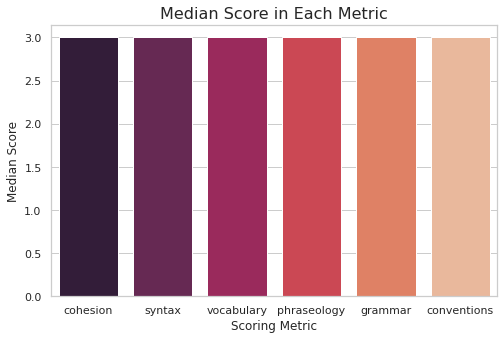

In [ ]:
get_barplot_for_each_label(df_train, label_cols, '_median_score')

# **Most Frequent Words**

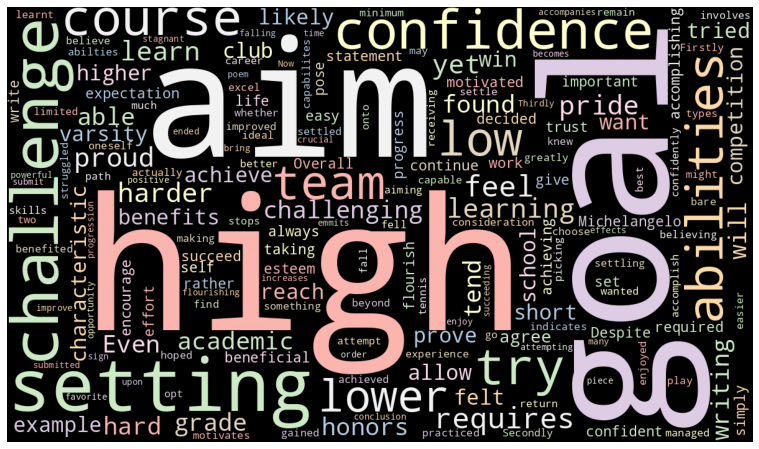

In [ ]:
text = df_train[df_train[label_cols].sum(axis=1)==30]['full_text'].values[0]
word_cloud = WordCloud(stopwords=STOPWORDS, colormap='Pastel1', collocations=False, width=1200, height=700, background_color = "black").generate(text)
plt.figure(figsize=(20,8))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()
     

# **Model Building**

In [ ]:
#make it easier to use a variety of BERT subword models
model_checkpoint = 'bert-base-cased'   # case sensitive (care about upper and lower case)
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
MAX_LENGTH = 512

# **Generate Input Embeddings - Train/Validation/Test Set**

In [ ]:
X_train, X_val, X_test = df_train['full_text'], df_val['full_text'], df_test['full_text']
y_train_map, y_val_map, y_test_map = np.array(df_train[label_map_cols]), np.array(df_val[label_map_cols]), np.array(df_test[label_map_cols])
y_train, y_val, y_test = np.array(df_train[label_cols]), np.array(df_val[label_cols]), np.array(df_test[label_cols])
y_train_scaled, y_val_scaled, y_test_scaled = np.array(df_train[label_rounded_cols]), np.array(df_val[label_rounded_cols]), np.array(df_test[label_rounded_cols])

y_train_map_combined, y_test_map_combined, y_val_map_combined = get_label_dict(df_train, label_map_cols, cat_label_cols), get_label_dict(df_test, label_map_cols, cat_label_cols), get_label_dict(df_val, label_map_cols, cat_label_cols)

In [ ]:
y_train_map_combined

{'cat_cohesion': array([4, 4, 3, ..., 4, 4, 6]),
 'cat_syntax': array([2, 6, 3, ..., 3, 4, 7]),
 'cat_vocabulary': array([3, 4, 3, ..., 3, 4, 7]),
 'cat_phraseology': array([3, 5, 3, ..., 3, 3, 8]),
 'cat_grammar': array([3, 5, 4, ..., 3, 3, 6]),
 'cat_conventions': array([3, 4, 5, ..., 4, 5, 7])}

In [ ]:
train_encodings = bert_tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')
val_encodings = bert_tokenizer(X_val.tolist(), truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')
test_encodings = bert_tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')

In [ ]:
classification_loss_dict = {label : tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) for label in cat_label_cols}
classification_loss_dict

{'cat_cohesion': <keras.losses.SparseCategoricalCrossentropy at 0x7ff60a1a66d0>,
 'cat_syntax': <keras.losses.SparseCategoricalCrossentropy at 0x7ff60a0b9910>,
 'cat_vocabulary': <keras.losses.SparseCategoricalCrossentropy at 0x7ff60a0b9c70>,
 'cat_phraseology': <keras.losses.SparseCategoricalCrossentropy at 0x7ff60a0b9cd0>,
 'cat_grammar': <keras.losses.SparseCategoricalCrossentropy at 0x7ff60a0b9370>,
 'cat_conventions': <keras.losses.SparseCategoricalCrossentropy at 0x7ff60a0b96d0>}

In [ ]:
classification_metrics_dict = {label : 'accuracy' for label in cat_label_cols}
classification_metrics_dict

{'cat_cohesion': 'accuracy',
 'cat_syntax': 'accuracy',
 'cat_vocabulary': 'accuracy',
 'cat_phraseology': 'accuracy',
 'cat_grammar': 'accuracy',
 'cat_conventions': 'accuracy'}

In [ ]:
def create_bert_model(checkpoint = model_checkpoint,
                      num_classes = 9,   # [1, 1.5, 2, 2.5....4.5, 5]: 9 classes
                      number_of_hidden_layer = 1,
                      hidden_layer_node_count = 256,
                      dropout = 0.3,
                      learning_rate = 0.001,
                      trainable_flag = True,
                      retrain_layer_count = 999,#All layers are trainable
                      classification_regression_flag = 'C',
                      max_length = MAX_LENGTH):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    set_config_param()
    bert_model = TFBertModel.from_pretrained(checkpoint, name = 'bert_model')    
    if trainable_flag:
        if retrain_layer_count == 999:
            # Train all layers of the BERT model
            bert_model.trainable = True         
        else:
            retrain_layers_list = []
            for retrain_layer_number in range(retrain_layer_count):
                retrain_layers_list.append('retrain_layer_' + str(retrain_layer_number)) 
            print('retrain layers: ', retrain_layers_list)

            for weight in bert_model.weights:
                if not any([x in weight.name for layer in retrain_layers_list]):
                    #print('freezing: ', w)
                    weight._trainable = False
    else:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False 
    
    # Input layer
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}
                   
    # Bert output: being used as an input feature in the classification model below
    bert_out = bert_model(bert_inputs)        # full features as an input to the following classification model
    # pooler_output = bert_out[1]             # one vector for each
    cls_token = bert_out[0][:, 0, :]          # give us a raw CLS tokens

    # =========== END generate "input features" using BERT tokenizer ==================================

    # =========== BEGIN build a "multi-classification model" below passing the BERT input features ======
    layer_list = []
    for hidden_layer_number in range(number_of_hidden_layer):
        if hidden_layer_number == 0:
            hidden_layer = tf.keras.layers.Dense(units = hidden_layer_node_count
                                               , activation = 'relu'
                                               , name = 'hidden_layer_' + str(hidden_layer_number + 1)
                                                )(cls_token)
        else:
            hidden_layer = tf.keras.layers.Dense(units = hidden_layer_node_count
                                               , activation = 'relu'
                                               , name = 'hidden_layer_' + str(hidden_layer_number + 1)
                                                )(layer_list[-1])
        layer_list.append(hidden_layer)
        dropout_layer = tf.keras.layers.Dropout(dropout, name = 'dropout_layer_' + str(hidden_layer_number + 1))(hidden_layer) 
        layer_list.append(dropout_layer)

    if classification_regression_flag == 'C':
        # Output classification layer
        classification_cohesion = tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'cat_cohesion')(layer_list[-1]) 
        classification_syntax = tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'cat_syntax')(layer_list[-1])
        classification_vocabulary = tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'cat_vocabulary')(layer_list[-1])
        classification_phraseology = tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'cat_phraseology')(layer_list[-1])
        classification_grammar = tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'cat_grammar')(layer_list[-1])
        classification_conventions = tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'cat_conventions')(layer_list[-1])

        outputs = [classification_cohesion, 
                   classification_syntax, 
                   classification_vocabulary, 
                   classification_phraseology, 
                   classification_grammar, 
                   classification_conventions
                  ]
        classification_model = tf.keras.Model(inputs = [input_ids, 
                                                        token_type_ids, 
                                                        attention_mask
                                                       ], 
                                              outputs = outputs
                                             )
        classification_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
                                     loss = classification_loss_dict,
                                     metrics = classification_metrics_dict
                                    )                
        return classification_model

# **"bert_classification_model_1" is the baseline classification model with multilabel multi output. We are retraining the pre-trained model.**

In [ ]:
bert_classification_model_1 = create_bert_model(checkpoint = model_checkpoint,
                                                num_classes = 9,   # [1, 1.5, 2, 2.5....4.5, 5]: 9 classes
                                                number_of_hidden_layer = 1,
                                                hidden_layer_node_count = 256,
                                                dropout = 0.3,
                                                learning_rate = 0.01,
                                                trainable_flag = True,
                                                retrain_layer_count = 999,#All layers trainable
                                                classification_regression_flag = 'C',
                                                max_length = MAX_LENGTH
                                              )

print(bert_classification_model_1.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                              

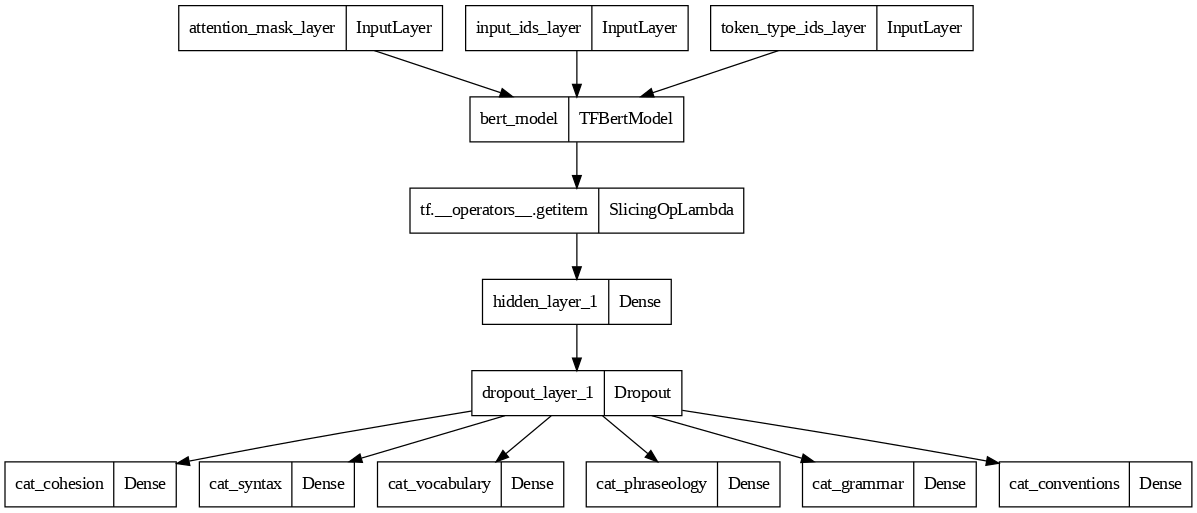

In [ ]:
keras.utils.plot_model(bert_classification_model_1, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

In [ ]:
bert_classification_model_1_history = bert_classification_model_1.fit([train_encodings.input_ids, 
                                                                       train_encodings.token_type_ids, 
                                                                       train_encodings.attention_mask
                                                                      ], 
                                                                      y_train_map_combined,   
                                                                      validation_data =([val_encodings.input_ids, 
                                                                                         val_encodings.token_type_ids, 
                                                                                         val_encodings.attention_mask
                                                                                        ], 
                                                                                        y_val_map_combined
                                                                                      ),    
                                                                      batch_size = 8, 
                                                                      epochs = 3
                                                                     )                                                  
bert_classification_model_1_history_df = pd.DataFrame(bert_classification_model_1_history.history)
bert_classification_model_1_history_df.T

Epoch 1/3


391/391 [==============================] - 420s 960ms/step - loss: 11.0513 - cat_cohesion_loss: 1.8816 - cat_syntax_loss: 1.8112 - cat_vocabulary_loss: 1.7522 - cat_phraseology_loss: 1.8495 - cat_grammar_loss: 1.9080 - cat_conventions_loss: 1.8487 - cat_cohesion_accuracy: 0.2634 - cat_syntax_accuracy: 0.3021 - cat_vocabulary_accuracy: 0.3747 - cat_phraseology_accuracy: 0.2724 - cat_grammar_accuracy: 0.2388 - cat_conventions_accuracy: 0.2855 - val_loss: 10.1643 - val_cat_cohesion_loss: 1.7028 - val_cat_syntax_loss: 1.7115 - val_cat_vocabulary_loss: 1.5740 - val_cat_phraseology_loss: 1.7033 - val_cat_grammar_loss: 1.7722 - val_cat_conventions_loss: 1.7005 - val_cat_cohesion_accuracy: 0.2711 - val_cat_syntax_accuracy: 0.3376 - val_cat_vocabulary_accuracy: 0.4041 - val_cat_phraseology_accuracy: 0.2839 - val_cat_grammar_accuracy: 0.2558 - val_cat_conventions_accuracy: 0.3018
Epoch 2/3
391/391 [==============================] - 357s 914ms/step - loss: 10.0722 - cat_cohesion_loss: 1.7008 - ca

,0,1,2
loss,11.051263,10.072247,10.031776
cat_cohesion_loss,1.881611,1.700760,1.694039
cat_syntax_loss,1.811225,1.672228,1.665574
cat_vocabulary_loss,1.752218,1.564393,1.557299
cat_phraseology_loss,1.849506,1.689980,1.682600
cat_grammar_loss,1.908048,1.735689,1.728483
cat_conventions_loss,1.848656,1.709193,1.703786
cat_cohesion_accuracy,0.263427,0.279412,0.276535
cat_syntax_accuracy,0.302110,0.317775,0.317455
cat_vocabulary_accuracy,0.374680,0.382992,0.382992


In [ ]:
bert_classification_model_1_history_df.columns

Index(['loss', 'cat_cohesion_loss', 'cat_syntax_loss', 'cat_vocabulary_loss',
       'cat_phraseology_loss', 'cat_grammar_loss', 'cat_conventions_loss',
       'cat_cohesion_accuracy', 'cat_syntax_accuracy',
       'cat_vocabulary_accuracy', 'cat_phraseology_accuracy',
       'cat_grammar_accuracy', 'cat_conventions_accuracy', 'val_loss',
       'val_cat_cohesion_loss', 'val_cat_syntax_loss',
       'val_cat_vocabulary_loss', 'val_cat_phraseology_loss',
       'val_cat_grammar_loss', 'val_cat_conventions_loss',
       'val_cat_cohesion_accuracy', 'val_cat_syntax_accuracy',
       'val_cat_vocabulary_accuracy', 'val_cat_phraseology_accuracy',
       'val_cat_grammar_accuracy', 'val_cat_conventions_accuracy'],
      dtype='object')

TypeError: ignored

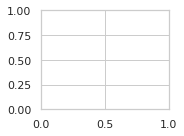

In [ ]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(2, 6, 1)
for idx, col in enumerate(cat_label_cols):
    ax[0, idx + 1].plot(bert_classification_model_1_history_df['val_' + col + '_loss'], lw=2, color='darkgoldenrod')
    ax[1, idx + 1].plot(bert_classification_model_1_history_df[col + '_loss'], lw=2, color='indianred')
    ax[idx + 1].legend(['Train', 'Validation'], fontsize=10)
    # plt.ylim(0,1)
    ax[idx + 1].set_xlabel('Epochs', size=10)
    ax[idx + 1].set_title('Loss');


In [ ]:
# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(bert_classification_model_1_history_df['loss'], lw=2, color='darkgoldenrod')
plt.plot(bert_classification_model_1_history_df['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
# plt.ylim(0,1)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(bert_classification_model_1_history_df['binary_accuracy'], lw=2, color='darkgoldenrod')
plt.plot(bert_classification_model_1_history_df['val_binary_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
# plt.ylim(0,1)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy')

In [ ]:
plot_history(bert_classification_model_1_history_df)

# **"bert_classification_model_2" is the baseline classification model with multilabel multi output. We are freezing the pre-trained model.**

In [ ]:
bert_classification_model_2 = create_bert_model(checkpoint = model_checkpoint,
                                                num_classes = 9,   # [1, 1.5, 2, 2.5....4.5, 5]: 9 classes
                                                number_of_hidden_layer = 1,
                                                hidden_layer_node_count = 256,
                                                dropout = 0.3,
                                                learning_rate = 0.01,
                                                trainable_flag = False,
                                                retrain_layer_count = 999,#All layers trainable
                                                classification_regression_flag = 'C',
                                                max_length = MAX_LENGTH
                                              )

print(bert_classification_model_2.summary())

In [ ]:
keras.utils.plot_model(bert_classification_model_2, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

In [ ]:
bert_classification_model_2_history = bert_classification_model_2.fit([train_encodings.input_ids, 
                                                                       train_encodings.token_type_ids, 
                                                                       train_encodings.attention_mask
                                                                      ], 
                                                                      y_train_map_combined,   
                                                                      validation_data =([val_encodings.input_ids, 
                                                                                         val_encodings.token_type_ids, 
                                                                                         val_encodings.attention_mask
                                                                                        ], 
                                                                                        y_val_map_combined
                                                                                      ),    
                                                                      batch_size = 8, 
                                                                      epochs = 3
                                                                     )                                                  
bert_classification_model_2_history_df = pd.DataFrame(bert_classification_model_2_history.history)
bert_classification_model_2_history_df.T

In [ ]:
plot_history(bert_classification_model_2_history_df)

In [ ]:
def train_separate_model_for_each_metrics(y_train_labels, y_valid_labels, target_cols, epochs=1):
  models = []
  for i in range(len(y_train_labels)):
    baseline_6_separate_model = create_6_separate_baseline_models()

    print(f'Train BERT for {target_cols[i].title()}........')
    baseline_6_separate_model_history = baseline_6_separate_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                                      y_train_separate_labels[i],   
                                                                      validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                                                       y_valid_separate_labels[i]),    
                                                                      batch_size=8, 
                                                                      epochs=epochs) 
    # Predict Scores for Test Set
    prediction_base_BERT = baseline_6_separate_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
    prediction_base_BERT = tf.argmax(prediction_base_BERT, axis=-1)
    print(f'Prediction Scores For {target_cols[i].title()}: {prediction_base_BERT}\n')

    models.append(baseline_6_separate_model)
  return models
     